### Unsupervised clustering results

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
sns.set(font_scale=1)
sns.set_style('ticks',{'axes.grid' : False})

figure_path = '/home/rohan/Dropbox/AllenInstitute/CellTypes/doc/Patchseq_NM_2020/'

In [7]:
D = pd.read_csv('/home/rohan/Remote-AI/dat/result/TE_CS/gmmfit_combined_perc_100-0_pca_20_cca_3_fiton_zT_minn_2_maxn_45.csv')
#D = pd.read_csv('/home/rohan/Remote-AI/dat/result/TE_CS/gmmfit_combined_perc_100-0_pca_50_cca_3_fiton_zT_minn_2_maxn_45.csv')
#D = pd.read_csv('/home/rohan/Remote-AI/dat/result/TE_CS/gmmfit_combined_perc_100-0_fiton_zT_aT_1-0_aE_1-0_cs_1-0_ad_1_minn_10_maxn_60.csv')
field_name = 'bic_train'
X_mean = D.groupby('n_components').mean()[[field_name]]
X_sd = D.groupby('n_components').std()[[field_name]]
best_n_components = X_mean[field_name].idxmin()

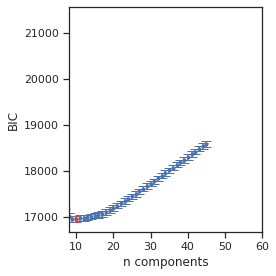

In [8]:
plt.figure(figsize=(4,4))
plt.errorbar(x=X_mean.index.values,
             y=X_mean[field_name].values,
             yerr=X_sd[field_name].values,
             fmt='.',
             capsize=5)

plt.errorbar(x=best_n_components,
             y=X_mean[field_name][best_n_components],
             yerr=X_sd[field_name][best_n_components],
             fmt='.',
             c='r',
             capsize=3)

ax = plt.gca()
ax.set_xlabel('n components')
ax.set_ylabel('BIC')
ax.set_xlim(8,51)
ax.set_xticks(np.arange(10,61,10))
plt.tight_layout()
#plt.savefig(figure_path+'denovo_gmm_bic.png',dpi=300)

In [9]:
np.unique(D['cv'].values)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

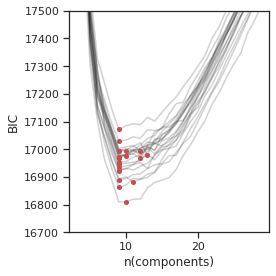

In [12]:
n_component_list=[]
bic_list=[]
plt.figure(figsize=(4,4))
for cv in range(20):
    Dd = D[D['cv']==cv]
    plt.plot(Dd['n_components'],Dd[field_name],'-k',alpha=0.2)
    temp = Dd.loc[Dd[field_name]==Dd[field_name].min()]
    bic_list.append(temp[field_name].values[0])
    n_component_list.append(temp['n_components'].values[0])

plt.plot(n_component_list,bic_list,'.r',markersize=8)
ax = plt.gca()
ax.set_xlabel('n(components)')
ax.set_ylabel('BIC')
ax.set_ylim(16700,17500)
ax.set_xlim(2,30)
ax.set_xticks(np.arange(10,21,10))
#plt.legend()
plt.tight_layout()
plt.savefig(figure_path+'20_CCA_aT_1_0_aE_1_0_cs_1_0_us_bic_cvsets.png',dpi=300)

In [31]:
np.std(n_component_list)

1.2196310917650468

**Freedman-Diaconis rule** 

bin width $h = 2\times{IQ}\times{n^{−\frac{1}{3}}}$
 - IQ is the interquartile range
 - n is number of observations

In [13]:
from scipy.stats import iqr
FD_binwidth = 2*iqr(n_component_list)*(len(n_component_list))**(-1/3)

In [17]:
FD_binwidth
FD_binwidth = 2.174

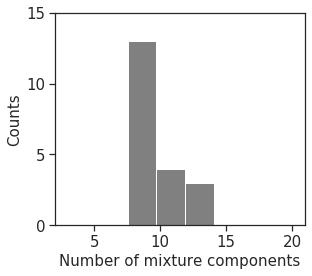

In [28]:
yy = n_component_list
fontsize = 15
plt.figure(figsize=(4.5,4))
plt.hist(yy,bins=np.arange(0.5,50,FD_binwidth)+0.5,color='gray')
ax = plt.gca()
ax.set_xlabel('Number of mixture components',fontsize=fontsize)
ax.set_ylabel('Counts',fontsize=15)


ax.set_xticks(np.arange(0,21,5))
ax.set_xlim(2,21)
ax.set_ylim(0,15)
ax.set_yticks(np.arange(0,16,5))
ax.set_yticklabels(np.arange(0,16,5).astype(int),fontsize=fontsize)

ax.set_xticklabels(ax.get_xticks(),fontsize=fontsize)
plt.tight_layout()
plt.savefig(figure_path+'cca_gmm_aT_1_0_aE_1_0_cs_1_0_ad_1_20cv_hist.png',dpi=300)
plt.show()

In [53]:
from scipy.stats import iqr
iqr_val = iqr(yy, axis=None, rng=[25, 75], scale=1.0, nan_policy='propagate', interpolation='linear', keepdims=False)
median_val = np.median(yy)
print(f'Number of clusters: median {np.median(yy)}, IQR: {iqr_val}')

Number of clusters: median 43.5, IQR: 7.0


### Consensus cluster analysis

In [14]:
# load fitted gmm model from file
import pickle
import numpy as np
import pandas as pd
import scipy.io as sio
from sklearn import mixture
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from pathlib import Path
from copy import deepcopy
from scipy.optimize import linear_sum_assignment
from refactor.utils.tree_helpers import get_merged_ordered_classes
from refactor.utils.plots import matrix_scatterplot
from refactor.utils.compute import contingency

%matplotlib inline

In [19]:
base_path = '/home/rohan/Remote-AI/'
representation_pth = base_path + 'dat/result/TE_CS/'
gmm_pth            = base_path + 'dat/result/TE_CS/gmm_model/'
origdata_pth       = base_path + 'dat/raw/patchseq-v4/PS_v5_beta_0-4_pc_scaled_ipxf_eqTE.mat'
figure_pth        = '/home/rohan/Dropbox/AllenInstitute/CellTypes/doc/Patchseq_NM_2020/'

#Get t-types in order as per reference taxonomy:
O = sio.loadmat(origdata_pth,squeeze_me=True)
n_required_classes = np.unique(O['cluster']).size
t_type_labels,t_types = get_merged_ordered_classes(data_labels=O['cluster'].copy(),
                                                   htree_file='./refactor/data/proc/dend_RData_Tree_20181220.csv',
                                                   n_required_classes=n_required_classes)

#well-sampled t-types:
min_sample_thr=10
t_types_well_sampled = []
for t in t_types:
    if np.sum(O['cluster']==t)>min_sample_thr:
        t_types_well_sampled.append(t)

#Representations
alpha_T=1.0
alpha_E=1.0
lambda_TE=1.0
aug = 1
fiton='zT'
cvfolds = np.arange(0,20,1)
ri = 0
modeltype='best_loss'

Performed 0 merges. Remaining classes in data = 59


In [21]:
#Load dataset with same test set, trained with different initializations:
XT_orig = O['T_dat']
XE_orig = np.concatenate([O['E_pc_scaled'],O['E_feature']],axis = 1)
mask_E = np.ones_like(XE_orig)
mask_E[np.isnan(XE_orig)]=0.0
XE_orig[np.isnan(XE_orig)]=0.0

CVdict={}
key_list = ['XrE','XrT','zE','zT','train_ind','val_ind']


for cv in tqdm(cvfolds):
    cvfold_fname=(f'CS_Edat_pcipfx_aT_{alpha_T:0.1f}_aE_{alpha_E:0.1f}_cs_{lambda_TE:0.1f}'+\
                  f'_ad_{aug:d}_ld_3_bs_200_se_500_ne_1500_cv_{cv:d}_ri_0_{modeltype}-summary').replace('.','-') + '.mat'
    
    if Path(representation_pth+cvfold_fname).is_file(): 
        X = sio.loadmat(representation_pth+cvfold_fname,squeeze_me=True)
        CVdict[cv] = {key:X[key] for key in key_list}
        CVdict[cv]['Emse'] = np.sum(mask_E*(X['XrE']-XE_orig)**2,axis=1)/np.sum(mask_E,axis=1)
        CVdict[cv]['Tmse'] = np.mean((X['XrT']-XT_orig)**2,axis=1)
        del X
    else:
        print(cvfold_fname,'not found')

100%|██████████| 20/20 [00:04<00:00,  4.15it/s]


**Get cluster labels based on GMM fit applied to zT and zE**

In [26]:
best_n_components = 43
for cv in CVdict.keys():
    fname = (f'gmmfit_perc_100-0_ld_3_fiton_zT_aT_{alpha_T:.1f}_aE_{alpha_E:.1f}'+\
             f'_cs_{lambda_TE:.1f}_ad_1_cv_{cv:d}_n_{best_n_components:d}').replace('.','-')+'.pkl'
    with open(gmm_pth+fname, 'rb') as fid:
        gmm = pickle.load(fid)

    #Label predictions using GMM fits:
    CVdict[cv]['ccT_lbl'] = gmm.predict(CVdict[cv]['zT'])
    CVdict[cv]['ccE_lbl'] = gmm.predict(CVdict[cv]['zE'])

In [27]:
#For each clustering, find the best ordering w.r.t. t-type labels:
for cv in CVdict.keys():
    C = contingency(a=t_type_labels.copy()[CVdict[cv]['train_ind']],
                    b=CVdict[cv]['ccT_lbl'][CVdict[cv]['train_ind']],
                    unique_a=t_types,
                    unique_b=np.arange(best_n_components))
    
    #Hungarian algorithm assignments:
    row_ind,col_ind = linear_sum_assignment(-C)
    C_ordered = C[:,col_ind]
    order_y = np.arange(0,best_n_components)[col_ind]

    CVdict[cv]['ccT_lbl_matched'] = CVdict[cv]['ccT_lbl'].copy()
    CVdict[cv]['ccE_lbl_matched'] = CVdict[cv]['ccE_lbl'].copy()

    for i in range(best_n_components):
        ind = CVdict[cv]['ccT_lbl'] == order_y[i]
        CVdict[cv]['ccT_lbl_matched'][ind] = i

        ind = CVdict[cv]['ccE_lbl'] == order_y[i]
        CVdict[cv]['ccE_lbl_matched'][ind] = i

In [44]:
from sklearn.metrics import adjusted_rand_score,normalized_mutual_info_score,adjusted_mutual_info_score
#All the labels are ordered at this point
sum_mse = []
acclist = []
for cv in CVdict.keys():
    
    inds = np.concatenate([CVdict[cv]['test_ind'],CVdict[cv]['train_ind']])
    #inds = CVdict[cv]['test_ind']
    
    #conservatively remove outliers based only on reconstruction errors:
    perc = 95
    Eoutlier_ind = np.flatnonzero(CVdict[cv]['Emse']<np.percentile(CVdict[cv]['Emse'],perc))
    Toutlier_ind = np.flatnonzero(CVdict[cv]['Tmse']<np.percentile(CVdict[cv]['Tmse'],perc))
    TE_keep = np.intersect1d(Eoutlier_ind,Toutlier_ind)
    inds = np.intersect1d(inds,TE_keep)

    CVdict[cv]['cc_inds'] = deepcopy(inds)
                                                             
    CVdict[cv]['C_t_type'] = contingency(a=t_type_labels[inds],
                                         b=CVdict[cv]['ccT_lbl_matched'][inds],
                                         unique_a=t_types_well_sampled,
                                         unique_b=np.arange(best_n_components))

    CVdict[cv]['C_consistency'] = contingency(a=CVdict[cv]['ccE_lbl_matched'][inds],
                                              b=CVdict[cv]['ccT_lbl_matched'][inds],
                                              unique_a=np.arange(best_n_components),
                                              unique_b=np.arange(best_n_components))
    ari = adjusted_rand_score(CVdict[cv]['ccT_lbl_matched'][inds],CVdict[cv]['ccE_lbl_matched'][inds])
    nmi = normalized_mutual_info_score(CVdict[cv]['ccT_lbl_matched'][inds],CVdict[cv]['ccE_lbl_matched'][inds])
    ami = adjusted_mutual_info_score(CVdict[cv]['ccT_lbl_matched'][inds],CVdict[cv]['ccE_lbl_matched'][inds])
    acc = np.sum(CVdict[cv]['ccT_lbl_matched'][inds]==CVdict[cv]['ccE_lbl_matched'][inds])/np.size(CVdict[cv]['ccE_lbl_matched'][inds])
    
    acclist.append(acc)
    #Print mse to select the best 
    sum_mse.append(np.mean(CVdict[cv]["Tmse"][inds])+np.mean(CVdict[cv]["Emse"][inds]))
    print(f'cv: {cv:2d}  '+\
          f'Tmse: {np.mean(CVdict[cv]["Tmse"][inds]):.2f}  '+\
          f'Emse: {np.mean(CVdict[cv]["Emse"][inds]):.2f}  '+\
          f'sum: {sum_mse[-1]:.3f}  '+\
          f'ari:{ari:0.3f}  nmi:{nmi:0.3f}  ami:{ami:0.3f}  acc:{acc:0.2f}')

cv:  0  Tmse: 1.81  Emse: 0.32  sum: 2.129  ari:0.335  nmi:0.617  ami:0.584  acc:0.47
cv:  1  Tmse: 1.82  Emse: 0.32  sum: 2.139  ari:0.328  nmi:0.622  ami:0.588  acc:0.49
cv:  2  Tmse: 1.81  Emse: 0.31  sum: 2.119  ari:0.344  nmi:0.624  ami:0.591  acc:0.50
cv:  3  Tmse: 1.82  Emse: 0.32  sum: 2.137  ari:0.308  nmi:0.620  ami:0.589  acc:0.51
cv:  4  Tmse: 1.83  Emse: 0.31  sum: 2.134  ari:0.247  nmi:0.594  ami:0.559  acc:0.44
cv:  5  Tmse: 1.82  Emse: 0.31  sum: 2.130  ari:0.290  nmi:0.595  ami:0.558  acc:0.47
cv:  6  Tmse: 1.82  Emse: 0.32  sum: 2.140  ari:0.319  nmi:0.599  ami:0.568  acc:0.45
cv:  7  Tmse: 1.82  Emse: 0.31  sum: 2.128  ari:0.355  nmi:0.618  ami:0.585  acc:0.46
cv:  8  Tmse: 1.81  Emse: 0.32  sum: 2.131  ari:0.351  nmi:0.622  ami:0.589  acc:0.48
cv:  9  Tmse: 1.83  Emse: 0.32  sum: 2.146  ari:0.304  nmi:0.602  ami:0.567  acc:0.48
cv: 10  Tmse: 1.82  Emse: 0.32  sum: 2.134  ari:0.350  nmi:0.619  ami:0.585  acc:0.52
cv: 11  Tmse: 1.82  Emse: 0.32  sum: 2.143  ari:0.312 

#### Stability of clusters

In [31]:
#Pick 5 of the best models based on MSE. 
#Choosing the model based on MSE is unrelated to the clustering task, 
#and is a way to minimize variance associated with network training. 
n_best_models = 5
best_model_ind = np.argsort(sum_mse)
best_model_ind = best_model_ind[0:n_best_models]

#### Comparison of clustering across different autoencoder initializations:

In [ ]:
from sklearn.metrics import adjusted_mutual_info_score

T_ami = np.full((n_best_models,n_best_models), np.nan)
E_ami = np.full((n_best_models,n_best_models), np.nan)

for subset in ['test_ind','train_ind']:
    for i,i_cv in enumerate(best_model_ind):
        for j,j_cv in enumerate(best_model_ind):
            if i>j:
                subset_ind_i = CVdict[i_cv][subset]
                subset_ind_j = CVdict[j_cv][subset]
                assert np.array_equal(subset_ind_i,subset_ind_j),'Error'
                
                T_ami[i,j] = adjusted_mutual_info_score(CVdict[i_cv]['ccT_lbl_matched'][subset_ind_i],
                                                        CVdict[j_cv]['ccT_lbl_matched'][subset_ind_j])
                
                E_ami[i,j] = adjusted_mutual_info_score(CVdict[i_cv]['ccE_lbl_matched'][subset_ind_i],
                                                        CVdict[j_cv]['ccE_lbl_matched'][subset_ind_j])

    print(f'T {subset} ami over pairwise compared models : {np.nanmean(T_ami):0.3f} + {np.nanstd(T_ami):0.3f}')
    print(f'E {subset} ami over pairwise compared models : {np.nanmean(E_ami):0.3f} + {np.nanstd(E_ami):0.3f}')

**Consistency across the modalities, after aligning the unsupervised types with t-types**

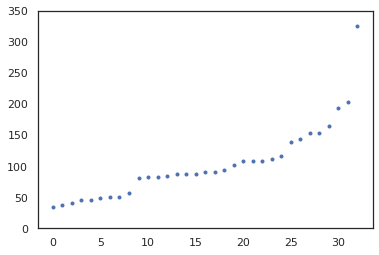

In [30]:
#Sorted count distribution across the types
(_,counts) = np.unique(CVdict[cv]['ccT_lbl_matched'],return_counts = True)
plt.figure(figsize=(7,3))
plt.bar(np.arange(counts.size),np.sort(counts))
ax = plt.gca()
ax.set_ylabel('Counts')
ax.set_xlabel('Consensus types sorted by count')
ax.set_ylim(0,350)
plt.show()

emp_P = np.sort(counts)/np.sum(counts)
uni_P = np.array([1/counts.size]*counts.size)
kl = np.sum(emp_P*np.log(emp_P/uni_P))
print(f'KL divergence wrt uniform distribution: {kl:0.3f}')
#fname='/home/rohan/Dropbox/AllenInstitute/CellTypes/doc/Patchseq_NM_2020/consensus_label_counts.mat'
#sio.savemat(fname,{'consensus_label_counts':counts})

frac_co_occupied = 0.977


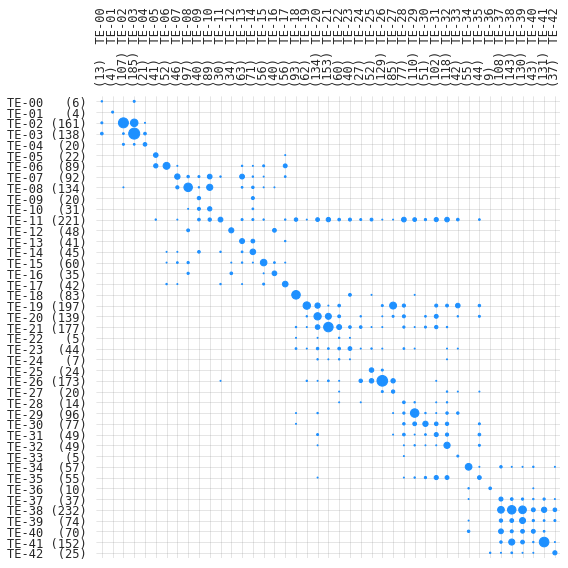

In [45]:
subset = 'test'

for cv in [2]:    
    xname = [f'TE-{y:02d}' for y in np.arange(best_n_components)]
    xdata = [f'({np.sum(CVdict[cv]["ccT_lbl_matched"][CVdict[cv]["cc_inds"]]==n):d})' for n in np.arange(best_n_components)]
    xlabelc = [f'{b:<6s}'+ f'{a:s}' for (a,b) in zip(xname,xdata)]
    
    yname = [f'TE-{y:02d}' for y in np.arange(best_n_components)]
    ydata = [f'({np.sum(CVdict[cv]["ccE_lbl_matched"][CVdict[cv]["cc_inds"]]==n):d})' for n in np.arange(best_n_components)]
    ylabelc = [f'{a:6s}'+f'{b:>5s}' for (a,b) in zip(yname,ydata)]
    
    matrix_scatterplot(M = CVdict[cv]['C_consistency'],
                       xticklabels = xlabelc, 
                       yticklabels = ylabelc, 
                       xlabel='', 
                       ylabel='', 
                       fig_width=8, 
                       fig_height=8, 
                       scale_factor=1.0)

    C = CVdict[cv]['C_consistency'].copy()
    print(f'frac_co_occupied = {np.sum(np.diag(C>0))/C.shape[0]:0.3f}')
    
    #plt.savefig(f'{figure_pth}TE_{subset}_cv_{cv:d}_zT_n_{best_n_components:d}.png',dpi=300)
    plt.show()

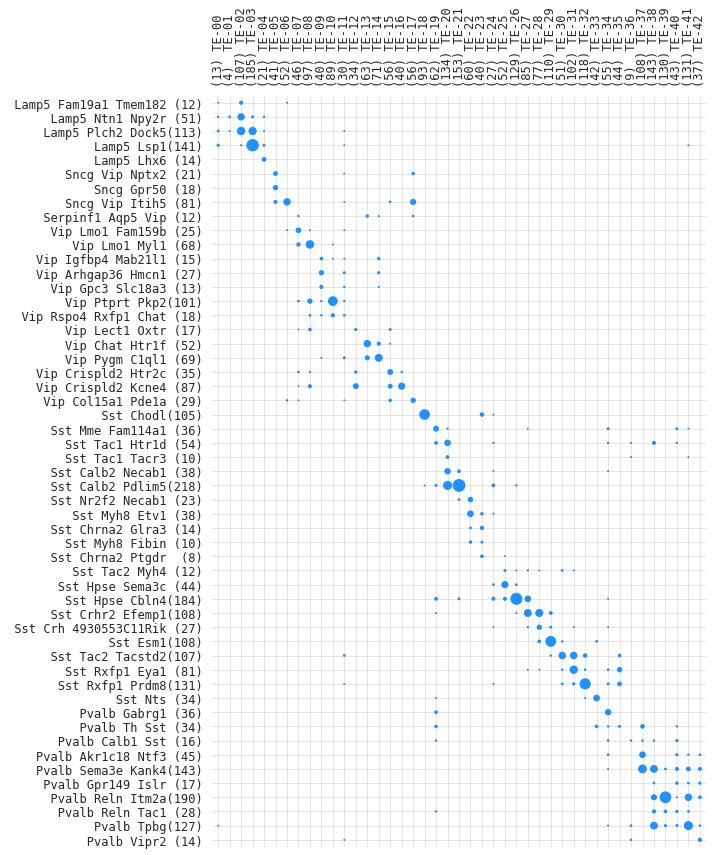

In [47]:
for cv in [2]:    
    xname = [f'TE-{y:02d}' for y in np.arange(best_n_components)]
    xdata = [f'({np.sum(CVdict[cv]["ccT_lbl_matched"][CVdict[cv]["cc_inds"]]==n):d})' for n in np.arange(best_n_components)]
    xlabelc = [f'{b:<4s}'+ f'{a:>6s}' for (a,b) in zip(xname,xdata)]
    
    yname = [f'{t.rstrip()}' for t in t_types_well_sampled]
    ydata = [f'({np.sum(O["cluster"][CVdict[cv]["cc_inds"]]==t)})' for t in t_types_well_sampled]
    ylabelc = [f'{a:>22s}'+f'{b:>5s}' for (a,b) in zip(yname,ydata)]
    
    matrix_scatterplot(M = CVdict[cv]['C_t_type'],
                       xticklabels = xlabelc, 
                       yticklabels = ylabelc, 
                       xlabel='', 
                       ylabel='', 
                       fig_width=10, 
                       fig_height=12, 
                       scale_factor=1.0)
    
    #plt.savefig(f'{figure_pth}TE-t-type_{subset}_cv_{cv:d}_zT_n_{best_n_components:d}.png',dpi=300)
    plt.show()

In [ ]:
sio.savemat('/home/rohan/Dropbox/AllenInstitute/CellTypes/dat/raw/patchseq-v4/consensus_cluster.mat',
            {'consensus_cluster':np.array([f'TE-{x:02d}' for x in CVdict[11]['ccT_lbl_matched']]),
            'consensus_cluster_id':CVdict[11]['ccT_lbl_matched']})